# Coffee shops reviews sentiment analysis with python


Imagine you are moving to a new city where you have never been before, and additionally you are crazy foodies. Obviously, you want to discover the best coffee shops in your brand new neighbourhood (or you are considering between some districts and want to compare them). As you now, mouth publicity is the most efficient way of marketing promotion so fist thing that you are doing is reading some google reviews. But it is almost impossible to manually evaluate each comment.

What you can do is build model that will classify customers' attitude towards service and food based on given reviews.

Customer satisfaction is vital for every business, and such model can be used to enhance business opportunities and improve customers experiences.

The purpose of this project is to build the NLP model, that will we able to decide whether the attender had positive, neutral or negative impression after visiting coffee shops.

The data is scrapped from google place reviews and consists of 1165 reviews of Surry Hills coffee shops (20) in Sydney, Australia.

This project has several steps:

1. Data exploration
2. Data preprocessing
    - removing punctutiations and stop words
    - data stemming and lemmatization
    - vectorization with Count Vectorizer and TF-ID
3. Data visualization (frequency distribution and word cloud)
4. Modeling
    - Multinomial Naive Bayes
    - Logistic Regression
    - Xgboost Classification
5. Testing
6. Attempt to improve the outcome with n-grams


Reviews with score 1.0 and 2.0 will be assigned to negative sentiment, 3.0 and 4.0 will indicate neutral attitude and 5.0 will respond for positive sentiment.


## Set up

In [2]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(9.7,6.27)})
sns.set_style("white")

import warnings
warnings.filterwarnings("ignore")


from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer


from wordcloud import WordCloud

from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ovtsho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('data/surry_hills_coffee_reviews.csv')
df.head(5)

,page,name,link,thumbnail,rating,date,snippet,images,local_guide,CoffeeShop
0,1,J Wang,https://www.google.com/maps/contrib/1066405393...,https://lh3.googleusercontent.com/a/ALm5wu2QSW...,1.0,10 months ago,Ordered take away lunch and received this burn...,['https://lh5.googleusercontent.com/p/AF1QipNc...,True,Paramount Coffee Project
1,1,Manish Rai,https://www.google.com/maps/contrib/1087306153...,https://lh3.googleusercontent.com/a/ALm5wu0hYM...,1.0,6 months ago,"TLDR/Long story short: Wrong pricing online, o...",['https://lh5.googleusercontent.com/p/AF1QipO-...,NaN,Paramount Coffee Project
2,1,Lisa,https://www.google.com/maps/contrib/1090187054...,https://lh3.googleusercontent.com/a-/ACNPEu-sy...,1.0,3 months ago,Drinks order was taken and drinks never arrive...,NaN,NaN,Paramount Coffee Project
3,1,Angel Manuel,https://www.google.com/maps/contrib/1127216205...,https://lh3.googleusercontent.com/a-/ACNPEu850...,1.0,2 months ago,"I came here twice, poor service. I ordered gre...",NaN,NaN,Paramount Coffee Project
4,1,Jisoo,https://www.google.com/maps/contrib/1168975833...,https://lh3.googleusercontent.com/a/ALm5wu25sD...,1.0,a year ago,We came here because the coffee shop we were g...,['https://lh5.googleusercontent.com/p/AF1QipOG...,NaN,Paramount Coffee Project


## Data exploration

In [4]:
# Check whether there are some rows with empty review
df[df.snippet.isnull()]

,page,name,link,thumbnail,rating,date,snippet,images,local_guide,CoffeeShop
28,1,Mann Hing Khor,https://www.google.com/maps/contrib/1157018408...,https://lh3.googleusercontent.com/a-/ACNPEu91h...,2.0,a year ago,NaN,NaN,True,Neighbourhood Speciality coffee


In [5]:
# Remove empty record
df = df[~df.snippet.isnull()].reset_index(drop=True)

In [6]:
# Check duplicates
df[df.duplicated('snippet')]

,page,name,link,thumbnail,rating,date,snippet,images,local_guide,CoffeeShop


In [7]:
# Explore distribution of scoring
df.groupby('rating')['snippet'].count()

rating
1.0    258
2.0    128
3.0    137
4.0    166
5.0    475
Name: snippet, dtype: int64

In [8]:
data = df.groupby('rating')['snippet'].count()
data

rating
1.0    258
2.0    128
3.0    137
4.0    166
5.0    475
Name: snippet, dtype: int64

In [9]:
data = data.to_frame().reset_index()

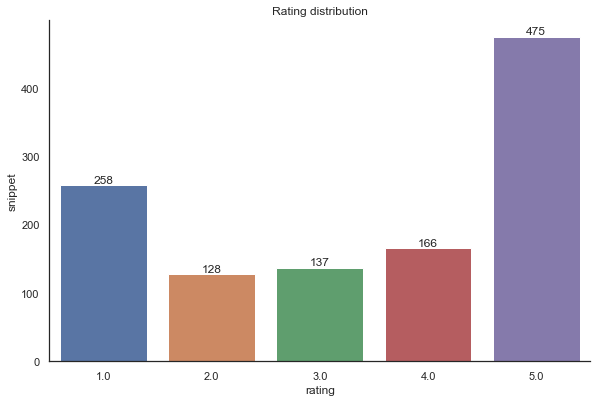

In [10]:
# Explore distribution of scoring
ax = sns.barplot(data=data, x='rating', y="snippet")
ax.bar_label(ax.containers[0])
ax.set(title='Rating distribution')
sns.despine()

Reviews with score 1.0 and 2.0 will be assigned with negative sentiment, 3.0 and 4.0 will indicate neutral attitude and 5.0 will respond for positive sentiment.

In [11]:
# Assign labels
df['sentiment']=df['rating'].apply(lambda x: 1 if x==5  else -1 if 0<x<3 else 0)
df['sentiment_desc']=df['rating'].apply(lambda x: 'positive' if x==5  else 'negative' if 0<x<3 else 'neutral')

In [12]:
#df['sentiment']=df['rating'].apply(lambda x: 1 if x>4  else 0)

In [13]:
# Check if it works
df[['snippet', 'rating', 'sentiment']].head(5)

,snippet,rating,sentiment
0,Ordered take away lunch and received this burn...,1.0,-1
1,"TLDR/Long story short: Wrong pricing online, o...",1.0,-1
2,Drinks order was taken and drinks never arrive...,1.0,-1
3,"I came here twice, poor service. I ordered gre...",1.0,-1
4,We came here because the coffee shop we were g...,1.0,-1


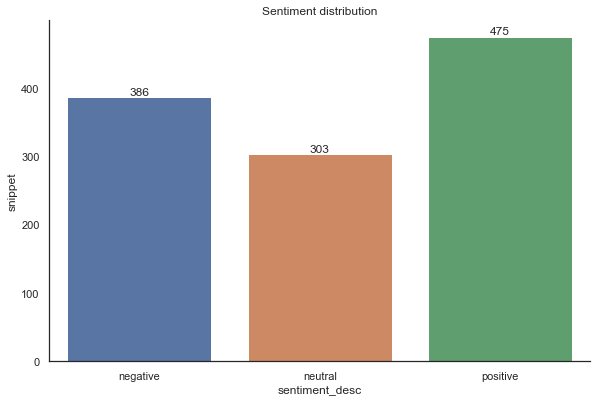

In [14]:
# Explore distribution of sentiment
data2 = df.groupby('sentiment_desc')['snippet'].count()
data2 = data2.to_frame().reset_index()
ax = sns.barplot(data=data2, x='sentiment_desc', y="snippet")
ax.bar_label(ax.containers[0])
ax.set(title='Sentiment distribution')
sns.despine()

We can conclude that this dataset is pretty balanced. But it depends on the way how labels were assigned to the score.

In [15]:
data

,rating,snippet
0,1.0,258
1,2.0,128
2,3.0,137
3,4.0,166
4,5.0,475


In [16]:
negative_prop = round(len(df[df.sentiment==-1])/len(df), 2)
neutral_prop = round(len(df[df.sentiment==0])/len(df), 2)
positive_prop = round(len(df[df.sentiment==1])/len(df), 2)

In [17]:
target_df = pd.DataFrame({'sentiment': ['negative', 'neutral', 'positive'],
                            'proportions': [negative_prop, neutral_prop, positive_prop]})

In [18]:
print ('This dataset is balanced: '
       'negative reviews: %s, '
       'neutral reviews: %s, '
       'positive reviews: %s' %
       (str(negative_prop),
        str(neutral_prop),
        str(positive_prop)))

This dataset is balanced: negative reviews: 0.33, neutral reviews: 0.26, positive reviews: 0.41


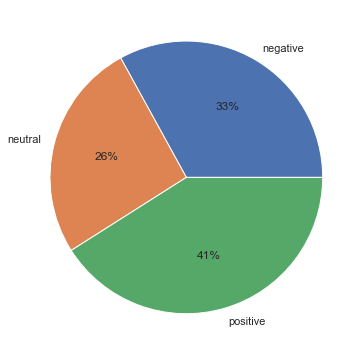

In [19]:
plt.pie(target_df['proportions'], labels = target_df['sentiment'], autopct='%.0f%%')
plt.show()

## Data Preprocessing

In [20]:
#Select only needed columns
data = df[['snippet', 'sentiment']]

In [21]:
data.head(5)

,snippet,sentiment
0,Ordered take away lunch and received this burn...,-1
1,"TLDR/Long story short: Wrong pricing online, o...",-1
2,Drinks order was taken and drinks never arrive...,-1
3,"I came here twice, poor service. I ordered gre...",-1
4,We came here because the coffee shop we were g...,-1


All punctuations should be removed

In [22]:
# Remove punctuations
data['tidy_snippet'] = data['snippet'].str.replace("[^a-zA-Z#]", " ")

Remove unusufull words using list of english stop words defined in nltk package. Additionally, some custom words releted to coffee,  that could be present in each review, were removed.

In [23]:
# Prepare list of stops words from nltk
stop_words=stopwords.words('english')

In [24]:
# Define custom stop words
my_stop_words = ['coffee','cafe', 'food', 'today', 'yesterday', 'place', 'staff', 'breakfast']

In [25]:
# Combine two lists
stop_words = stop_words + my_stop_words

In [26]:
# Remove stop words
data['tidy_snippet'] = data['tidy_snippet'].apply(lambda x: ' '.join([w for w in x.lower().split() if w not in stop_words]))

### For the next step there are two options: stemming or lemmatization.

Stemming is a process that stems or removes last few characters from a word, often leading to incorrect meanings and spelling.
Lemmatization considers the context and converts the word to its meaningful base form, which is called Lemma.

Both options were checked bellow.



In [27]:
## Stemming
stemmer=PorterStemmer()
data['stem_snippet']  = data['tidy_snippet'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [28]:
## Lemmatization
lemmatizer = WordNetLemmatizer()
data['lem_snippet'] = data['tidy_snippet'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [29]:
# Check out differences
data[['tidy_snippet', 'stem_snippet', 'lem_snippet']].head(5)

,tidy_snippet,stem_snippet,lem_snippet
0,ordered take away lunch received burned toasti...,order take away lunch receiv burn toasti hidde...,ordered take away lunch received burned toasti...
1,tldr long story short wrong pricing online ove...,tldr long stori short wrong price onlin overpr...,tldr long story short wrong pricing online ove...
2,drinks order taken drinks never arrived chase ...,drink order taken drink never arriv chase get ...,drink order taken drink never arrived chase ge...
3,came twice poor service ordered green tea rece...,came twice poor servic order green tea receiv ...,came twice poor service ordered green tea rece...
4,came shop gonna go closed ordered housemade gr...,came shop gonna go close order housemad granol...,came shop gonna go closed ordered housemade gr...


In [30]:
# Two X prepared separately
X_stem = data['stem_snippet']
X_lem = data['lem_snippet']
y = data['sentiment']

### Vectorization


Vectorization is the process of converting text into numerical data (vectors), which is vital step in every NLP project.

Two options will be exlored: Vectorization and TD-IDF

1. Count Vectorizer is a way to convert a given set of strings into a frequency representation (Bag of Words).
2. TF-IDF focuses not only on the frequency of words present in the corpus but also provides the importance of the words

In other word, in this project models build on data prepared with 4 different settings will be assessed. Namely:
- Stemmed data prepared witt Count Vectorizer
- Stemmed data prepared with TF-IDF
- Lemmatized data prepared witt Count Vectorizer
- Lemmatized data prepared with TF-IDF

The CountVectorizer and TF-IDF  will choose the 3000 words/features that occur most frequently and drop everything else.


In [31]:
# Count Vectorizer with stemming
cv_stem=CountVectorizer(max_features=3000)
X_count_vec_stem =cv_stem.fit_transform(X_stem)

In [32]:
# Count Vectorizer with lemmatization
cv_lem=CountVectorizer(max_features=3000)
X_count_vec_lem = cv_lem.fit_transform(X_lem)

In [33]:
# TD-IDF with stemming
tfidf_stem =TfidfVectorizer(max_features=3000)
X_tfidf_stem =tfidf_stem.fit_transform(X_stem)

In [34]:
# TD-IDF with lemmatization data
tfidf_lem =TfidfVectorizer(max_features=3000)
X_tfidf_lem =tfidf_lem.fit_transform(X_lem)

### Data visualization

After cleaning and preparing the data, let's explore most frequent word

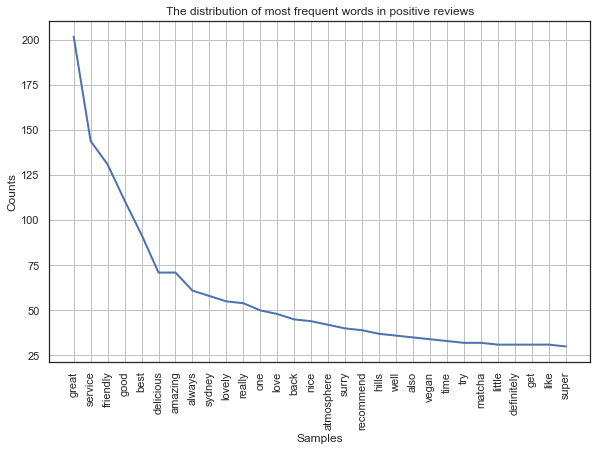

<AxesSubplot:title={'center':'The distribution of most frequent words in positive reviews'}, xlabel='Samples', ylabel='Counts'>

In [35]:
# Positive words
positive = data[data.sentiment == 1]
a = positive['tidy_snippet'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist_pos = nltk.FreqDist(words)
word_dist_pos.plot(30, cumulative=False, title='The distribution of most frequent words in positive reviews')

But we can also try it with sns bar plot

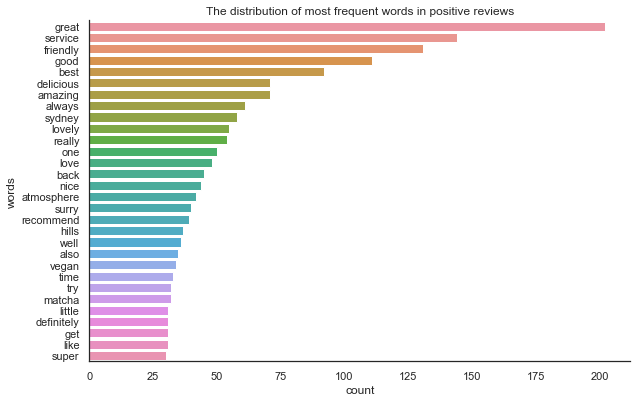

In [36]:
df_pos = pd.DataFrame({'words':list(word_dist_pos.keys()),'count':list(word_dist_pos.values())})
df_po_plot = df_pos.nlargest(30,columns='count')

sns.barplot(data=df_po_plot,y='words',x='count').set_title('The distribution of most frequent words in positive reviews')
sns.despine()

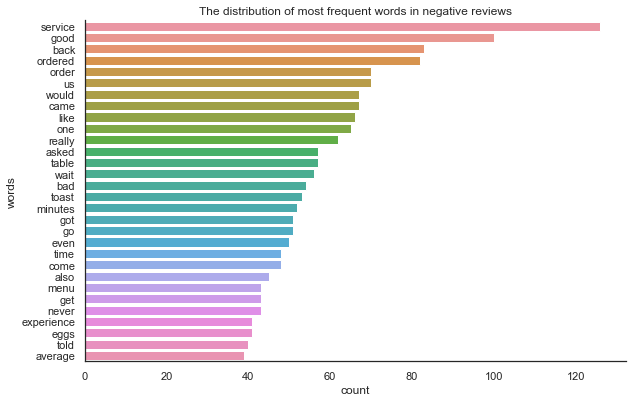

In [37]:
## Let's do the same for negative sentiment
negative = data[data.sentiment == -1]
b = negative['tidy_snippet'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(b)
word_dist_neg = nltk.FreqDist(words)

df_neg = pd.DataFrame({'words':list(word_dist_neg.keys()),'count':list(word_dist_neg.values())})
df_neg_plot = df_neg.nlargest(30,columns='count')

sns.barplot(data=df_neg_plot, y='words',x='count').set_title('The distribution of most frequent words in negative reviews')
sns.despine()


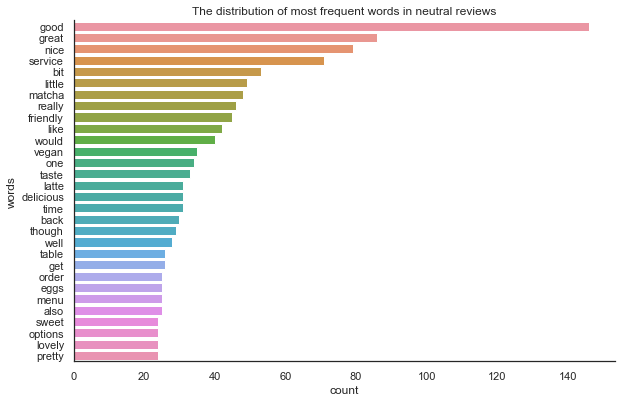

In [38]:
## and neutral
neutral = data[data.sentiment == 0]
c = neutral['tidy_snippet'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(c)
word_dist_neu = nltk.FreqDist(words)

df_neu = pd.DataFrame({'words':list(word_dist_neu.keys()),'count':list(word_dist_neu.values())})
df_neu_plot = df_neu.nlargest(30,columns='count')

sns.barplot(data=df_neu_plot, y='words',x='count').set_title('The distribution of most frequent words in neutral reviews')
sns.despine()

### Word Cloud

The most frequent words can be discovered with word cloud, as well

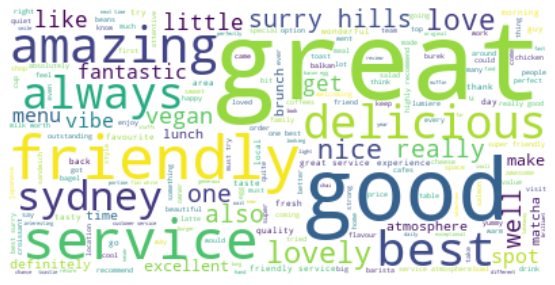

In [39]:
positive = data[data.sentiment == 1]['tidy_snippet']
text_p = " ".join(review for review in positive)

# Generate a word cloud image
wordcloud_p = WordCloud(stopwords=stop_words, background_color="white").generate(text_p)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_p, interpolation='bilinear')
plt.axis("off")
plt.show()

The same for negative

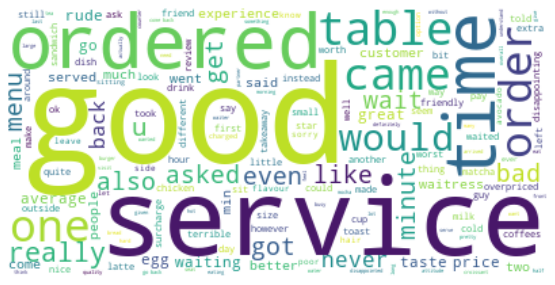

In [40]:
negative = data[data.sentiment == -1]['tidy_snippet']
text_n = " ".join(review for review in negative)

# Generate a word cloud image
wordcloud_n = WordCloud(stopwords=stop_words, background_color="white").generate(text_n)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_n, interpolation='bilinear')
plt.axis("off")
plt.show()

### Building models

Different models will be examined:
- Multinomial Naive Bayes
- Logistic Regression
- Xgboost Classification

#### 1. Multinomial NB

Multionomial Naive Bayes will examined with 4 settings

In [41]:
## Multinomial NB, Count Vectorizer, stemming
model1_nb =MultinomialNB()
X_train,X_test,y_train,y_test =train_test_split(X_count_vec_stem, y, test_size=0.3, random_state=100)
model1_nb.fit(X_train,y_train)

y_pred_nb_cv_st =model1_nb.predict(X_test)

cf1=classification_report(y_test,y_pred_nb_cv_st)
print(cf1)

accuracy_nb1 = accuracy_score(y_test,y_pred_nb_cv_st)
print('Accuracy Multinomial NB with Count Vectorizer and Data Stemming ' + str(round(accuracy_nb1,2)))

              precision    recall  f1-score   support

          -1       0.86      0.82      0.84       110
           0       0.65      0.48      0.55        82
           1       0.80      0.94      0.86       158

    accuracy                           0.79       350
   macro avg       0.77      0.74      0.75       350
weighted avg       0.78      0.79      0.78       350

Accuracy Multinomial NB with Count Vectorizer and Data Stemming 0.79


In [42]:
## Multinomial NB, Count Vectorizer, lemmatization
model2_nb=MultinomialNB()
X_train,X_test,y_train,y_test =train_test_split(X_count_vec_lem,y,test_size=0.3, random_state=100)
model2_nb.fit(X_train,y_train)

y_pred_cv_lem =model2_nb.predict(X_test)

cf2=classification_report(y_test,y_pred_cv_lem)
print(cf2)

accuracy_nb2 = accuracy_score(y_test,y_pred_cv_lem)
print('Accuracy Multinomial NB with Count Vectorizer and Data Lemmatization data ' + str(round(accuracy_nb2,2)))

              precision    recall  f1-score   support

          -1       0.85      0.79      0.82       110
           0       0.59      0.46      0.52        82
           1       0.80      0.93      0.86       158

    accuracy                           0.78       350
   macro avg       0.75      0.73      0.73       350
weighted avg       0.77      0.78      0.77       350

Accuracy Multinomial NB with Count Vectorizer and Data Lemmatization data 0.78


In [43]:
## Multinomial NB, TF-IDF, stemming
model3_nb=MultinomialNB()
X_train,X_test,y_train,y_test =train_test_split(X_tfidf_stem,y,test_size=0.3, random_state=100)
model3_nb.fit(X_train,y_train)

y_pred_td_stem =model3_nb.predict(X_test)

cf3=classification_report(y_test,y_pred_td_stem)
print(cf3)

accuracy_nb3 = accuracy_score(y_test,y_pred_td_stem)
print('Accuracy Multinomial NB, TF-IDF, stemming ' + str(round(accuracy_nb3, 2)))

              precision    recall  f1-score   support

          -1       0.85      0.85      0.85       110
           0       0.86      0.22      0.35        82
           1       0.71      0.98      0.82       158

    accuracy                           0.76       350
   macro avg       0.81      0.69      0.68       350
weighted avg       0.79      0.76      0.72       350

Accuracy Multinomial NB, TF-IDF, stemming 0.76


In [44]:
## Multinomial NB, TF-IDF, lemmatization data
model4_nb =MultinomialNB()
X_train,X_test,y_train,y_test =train_test_split(X_tfidf_lem,y,test_size=0.3, random_state=100)
model4_nb.fit(X_train,y_train)

y_pred_td_lem =model4_nb.predict(X_test)

cf4=classification_report(y_test,y_pred_td_lem)
print(cf4)

accuracy_nb4 = accuracy_score(y_test,y_pred_td_lem)
print('Accuracy Multinomial NB, TF-IDF, lemmatization data ' + str(round(accuracy_nb4, 2)))

              precision    recall  f1-score   support

          -1       0.84      0.84      0.84       110
           0       0.82      0.22      0.35        82
           1       0.71      0.98      0.82       158

    accuracy                           0.76       350
   macro avg       0.79      0.68      0.67       350
weighted avg       0.78      0.76      0.72       350

Accuracy Multinomial NB, TF-IDF, lemmatization data 0.76


According to the accuracy, data prepared with Data Stemming and Count Vectorizer produces better outcome. Thus, next models will be built with these settings only.


In [45]:
X_train,X_test,y_train,y_test =train_test_split(X_count_vec_stem,y,test_size=0.3, random_state=100)

## 2. Logistic Regression

In [46]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr.fit(X_train,y_train)

y_pred_count_stem_lr =lr.predict(X_test)
print(classification_report(y_pred_count_stem_lr,y_test))

accuracy_lr = accuracy_score(y_test,y_pred_count_stem_lr)
print('Accuracy Logistic Regression' + str(round(accuracy_lr,2)))

              precision    recall  f1-score   support

          -1       0.72      0.85      0.78        93
           0       0.50      0.49      0.50        83
           1       0.86      0.78      0.82       174

    accuracy                           0.73       350
   macro avg       0.69      0.71      0.70       350
weighted avg       0.74      0.73      0.73       350

Accuracy Logistic Regression0.73


## 3. Xgboost Classifier

In [47]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=100, objective='multi:softmax', num_class=3)
xgb.fit(X_train,y_train)

y_pred_count_stem_xgb =xgb.predict(X_test)

print(classification_report(y_pred_count_stem_xgb,y_test))

accuracy_xgb = accuracy_score(y_test,y_pred_count_stem_xgb)
print('Accuracy Xgboost Classifier ' + str(round(accuracy_xgb,2)))

[15:01:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

          -1       0.72      0.77      0.75       102
           0       0.49      0.49      0.49        81
           1       0.84      0.79      0.81       167

    accuracy                           0.72       350
   macro avg       0.68      0.69      0.68       350
weighted avg       0.72      0.72      0.72       350

Accuracy Xgboost Classifier 0.72


Let's plot result to compare the outcomes

In [48]:
results = pd.DataFrame({'model':['Multinomial Naive Bayes',
                                 'Multinomial Logistic Regression',
                                 'Xgboost Classifier'],
                        'accuracy': [accuracy_nb1, accuracy_lr, accuracy_xgb]})

In [49]:
results['accuracy'] = results['accuracy'].apply(lambda x: round(x, 2))

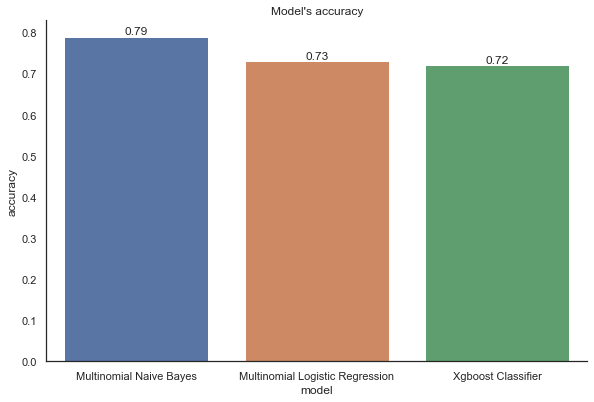

In [50]:

ax = sns.barplot(data=results, x='model', y="accuracy")
ax.bar_label(ax.containers[0])
ax.set(title="Model's accuracy")
sns.despine()

Multinomial Naive Bayes produce the most accurate results, so now we can test this model

First, I will prepare function that preprocess reviews

In [51]:
def predict_sentiment(text):
    if text =='':
        print('Invalid input')
    else:
        punct = re.sub('[^a-zA-Z]',' ', text)
        stop = punct.lower().split()
        cleaned = [w for w in stop if w not in stop_words]
        steamed = [stemmer.stem(word) for word in cleaned]
        final = cv_stem.transform(steamed).toarray()
        prediction =  model1_nb.predict(final)
        if prediction[0] == 1:
            print( "Positive" )
        elif prediction[0] == 0:
            print( "Neutral")
        else:
            print( "Negative")

In [52]:
predict_sentiment('very good place')
# Correct!

Positive


In [53]:
predict_sentiment('Charged me $8 for this. The highlight was the lemon. Making toast can be hard, but maybe you should practice a few times before you open a cafe. Good luck.')
# Correct!

Negative


In [54]:
predict_sentiment('2018 went in for a coffee, both my husband and I threw out the coffee - lucky we took our own takeaway cup.  No longer a top coffee spot in sydney.')
# Correct!

Negative


In [55]:
predict_sentiment('Had a delicious coffee to accompany some perfect scrambled eggs, sautéed mushrooms laid on a fresh croissant. It tasted as good as it looks in this picture! Nice ambience with plenty of seats. Will definitely visit again!')
# Correct!

Positive


In [56]:
predict_sentiment('Cheese omelette & mushrooms omelette are quite salty. but cutlery looks nice')
#Could be neutral

Positive


In [57]:
predict_sentiment('A nice small and intimate cafe. Good food and atmosphere.')
#Correct!

Neutral


In [58]:
predict_sentiment('Bring back the German food. It used to be a favourite place to dine, but the only great thing here now is the coffee. Alas, the meals are too big, and although pleasant enough, just as good as I make at home. I go out to try better food that will surprise me and bring me back, and I expect food to match the name. It could have been called Cabramatta Bakr')
#Correct!

Negative


In [59]:
predict_sentiment('On average it is a good place, but could be better coffee')
#Could be neutral, as well

Negative


So model performs  and perfectly distinct positive VS negative sentiments.
But it has some issues with neutral reviews. There could be several reasons behind this:
    - it was the smallest part in  training set
    - it is enormously subjective topic, and it also depends on the way how labels were assigned to scores. Maybe score 4 should also reflect positive attitude, and only score 3 should be assigned with neutral sentiment. As an illustration, some reviews can sound totally positive but the rating was 4 thus 'neutral sentiment' was assigned.
    - Perhaps, manual sentiment assignment can be handy.




## N-grams

I will try to improve model with n-grams
N-grams are continuous sequences of words or symbols or tokens in a document. They are the nearest sequences of items in a document.


In [60]:
for n in range(1,11):

    cv = CountVectorizer(max_features=3000, ngram_range=(1,n))
    X_count_vec_stem_ngram =cv.fit_transform(X_stem)

    # train model and generate predictions
    clf_ngram = MultinomialNB()
    X_train,X_test,y_train,y_test =train_test_split(X_count_vec_stem_ngram,y,test_size=0.3, random_state=100)
    clf_ngram.fit(X_train,y_train)
    y_pred_ngram = clf_ngram.predict(X_test)

    score = round(accuracy_score(y_test,y_pred_ngram),3)
    print('Accuracy score of model with n-gram range of {}: {}'.format((1,n), score))

Accuracy score of model with n-gram range of (1, 1): 0.791
Accuracy score of model with n-gram range of (1, 2): 0.766
Accuracy score of model with n-gram range of (1, 3): 0.76
Accuracy score of model with n-gram range of (1, 4): 0.763
Accuracy score of model with n-gram range of (1, 5): 0.769
Accuracy score of model with n-gram range of (1, 6): 0.771
Accuracy score of model with n-gram range of (1, 7): 0.769
Accuracy score of model with n-gram range of (1, 8): 0.763
Accuracy score of model with n-gram range of (1, 9): 0.78
Accuracy score of model with n-gram range of (1, 10): 0.774


Unfortunately, it doesn't improve the accuracy.

We can try build model that will predict only 2 classes: positive and negative.

## Let's try build model with only 2 classes

In [61]:
df['sentiment_2cl']=df['rating'].apply(lambda x: 1 if x>4  else 0)
y2 = df['sentiment_2cl']

In [62]:
## Multinomial NB, Count Vectorizer, data stemming
model1_nb_2cl =MultinomialNB()
X_train,X_test,y_train,y_test =train_test_split(X_count_vec_stem, y2, test_size=0.3, random_state=100)
model1_nb_2cl.fit(X_train,y_train)

y_pred_nb_cv_st =model1_nb_2cl.predict(X_test)

cf5=classification_report(y_test,y_pred_nb_cv_st)
print(cf5)

accuracy_nb5 = accuracy_score(y_test,y_pred_nb_cv_st)
print('Accuracy Multinomial NB with Count Vectorizer and stemming, 2 classes ' + str(round(accuracy_nb5,2)))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86       192
           1       0.80      0.91      0.85       158

    accuracy                           0.86       350
   macro avg       0.86      0.86      0.86       350
weighted avg       0.86      0.86      0.86       350

Accuracy Multinomial NB with Count Vectorizer and stemming, 2 classes 0.86


Now we see improvement in accuracy - the same model build for 3 classes has 79% of accuracy.
But we may lose some added value which is neutral sentiment classifying.

Let's test this simplifier model, but first we need to change function

In [63]:
def predict_sentiment_2cl(text):
    if text =='':
        print('Invalid input')
    else:
        punct = re.sub('[^a-zA-Z]',' ', text)
        stop = punct.lower().split()
        cleaned = [w for w in stop if w not in stop_words]
        steamed = [stemmer.stem(word) for word in cleaned]
        final = cv_stem.transform(steamed).toarray()
        prediction =  model1_nb_2cl.predict(final)
        if prediction[0] == 1:
            print( "Positive" )
        else:
            print( "Negative")


Let's check new model

In [64]:
predict_sentiment_2cl('Cheese omelette & mushrooms omelette are quite salty. but cutlery looks nice')
#Rather negative

Negative


In [65]:
predict_sentiment_2cl('could be better')
# Correct!

Negative


In [66]:
predict_sentiment_2cl('lovely and tasty')
# Correct!

Positive


In [67]:
predict_sentiment_2cl('Bring back the German food. It used to be a favourite place to dine, but the only great thing here now is the coffee. Alas, the meals are too big, and although pleasant enough, just as good as I make at home. I go out to try better food that will surprise me and bring me back, and I expect food to match the name. It could have been called Cabramatta Bakr')
# Correct!

Negative


In [68]:
predict_sentiment_2cl('Had a delicious coffee to accompany some perfect scrambled eggs, sautéed mushrooms laid on a fresh croissant. It tasted as good as it looks in this picture! Nice ambience with plenty of seats. Will definitely visit again!')
# Correct!

Positive


In [69]:
predict_sentiment_2cl("Amazing cakes and comfortable cafe. Only coffee lets this place down a little as it's just ok but this place is still worth the visit")
# Correct!

Positive


## Summary

To achieve purpose of this project several steps were performed:
    1.Data exploration
    2.Data preprocessing
    3.Data visualization
    4.Modeling
    5.Testing
    6.Attempt of improvements

The best model: Multinomial Naive Bayes build on 70% of dataset (prepared with Data Stemming and Count Vectorizer) has 79% of accuracy.

Obviously there is a place for improvements:
-   size of the dataset can be increased
-   other models can be examined
-   different approaches for labels assignment can be tried
-   parametr tunning and k-fold cross validation can be handy

